# Setup

## Imports

In [1]:
using Pkg
Pkg.activate("SCC", shared=true)


import QuantumToolbox as qt
import SuperconductingCavities as SC
import CairoMakie as cm
using Revise
using Dates
import JSON3

using YAXArrays

using ProgressMeter

import Optim as opt

using Logging
using MiniLoggers

using IJulia
if isdefined(Main, :IJulia)
    Main.IJulia.stdio_bytes[] = 0;
end


  Activating project at `~/.julia/environments/SCC`
[ Info: new driver key :netcdf, updating backendlist.


0

## Logger Setups

In [2]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

ConsoleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), Info, Base.CoreLogging.default_metafmt, true, 0, Dict{Any, Int64}())

In [3]:
Mode3 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3/Mode3.json");

In [17]:
to_print = sort(collect(values(Mode3.dressed_energies)))

the_string = ""
for i in 1:length(to_print)
    the_string *= string(to_print[i])*", "
    if i%5 ==0
        the_string *= "\n"
    end
end

println(the_string)

-24.64078956552129, -20.037119758689812, -18.411647497804225, -15.541685150376878, -13.808183529653093, 
-12.182505537673151, -11.158805955200407, -9.312928130797232, -7.579247362581398, -6.893413870963286, 
-5.9533636850899825, -4.9302069146888385, -3.0841711451174376, -2.751214721740652, -1.3503112574646678, 
-0.664956083248498, 0.2757780599831392, 1.2610832295990162, 1.2983921086875265, 3.1445858066609134, 
3.477114577655982, 4.878624785707629, 5.13544174542438, 5.563501696416132, 6.504919697584299, 
7.489292918534572, 7.526991114922506, 8.861960369629841, 9.373342724536712, 9.705443870923588, 
11.107560766945703, 11.36356096254164, 11.791959468017033, 12.429664585447014, 12.734061227751404, 
13.71750266088048, 13.755590104009618, 15.08998195735716, 15.60209960850839, 15.93377315809009, 
17.336496686260624, 17.59168053070144, 18.020417231540158, 18.653939469904607, 18.96320265060674, 
19.945712457051467, 19.984189075942634, 21.317997073743484, 21.830856458590475, 22.16210243918387, 

# Loading Model

In [4]:
Model = SC.Circuits.Transmon_Resonators.load("ModelSaves/ReadoutMode3/ReadoutMode3.json");

In [5]:
#run_res = SC.Utils.LoadRunResults("Data/ExploringReadoutReset_half_with_wait_eps.nc")
run_res = SC.Utils.LoadRunResults("Data/ExploringReadoutReset_fn0gn1_Comb_Long.nc")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5  …  2995.5, …
  "states" => Any[Quantum Object:   type=Operator   dims=[8, 6, 4]   size=(192,…

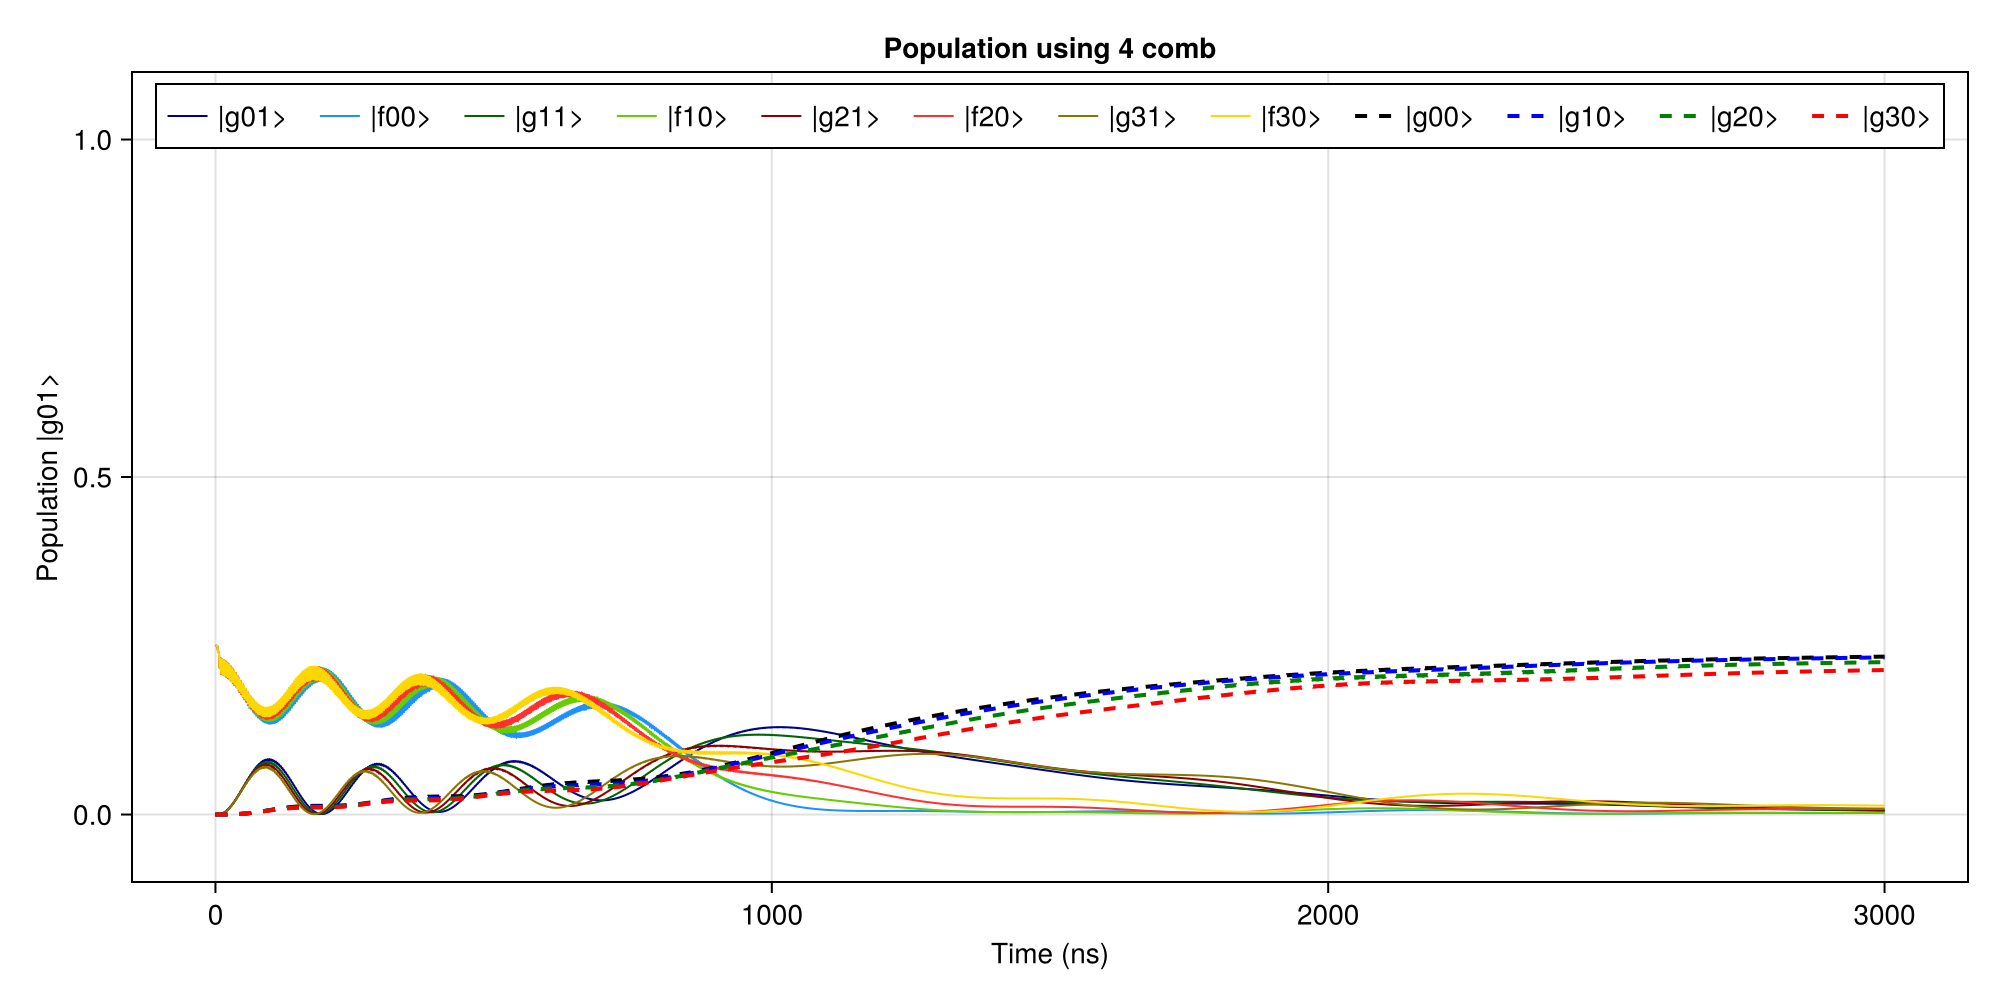

CairoMakie.Screen{IMAGE}


In [20]:
f = cm.Figure(size = (1000, 500))
ax = cm.Axis(f[1,1], title = "Population using 4 comb", xlabel = "Time (ns)", ylabel = "Population |g01>", limits = (nothing, (-0.1,1.1)))

ms = 0.1
lw = 1
alpha = 0.3
y = abs.([qt.expect(run_res["states"][i],Model.dressed_states[(0,0,1)]) for i in 1:length(run_res["states"])])
cm.scatterlines!(ax, run_res["times"], y, color = "darkblue", label = "|g01>", markersize = ms, alpha = alpha, linewidth = lw)
y = abs.([qt.expect(run_res["states"][i],Model.dressed_states[(2,0,0)]) for i in 1:length(run_res["states"])])
cm.scatterlines!(ax, run_res["times"], y, color = "dodgerblue", label = "|f00>", markersize = ms, alpha = alpha, linewidth = lw)

y = abs.([qt.expect(run_res["states"][i],Model.dressed_states[(0,1,1)]) for i in 1:length(run_res["states"])])
cm.scatterlines!(ax, run_res["times"], y, color = "darkgreen", label = "|g11>", markersize = ms, alpha = alpha, linewidth = lw)
y = abs.([qt.expect(run_res["states"][i],Model.dressed_states[(2,1,0)]) for i in 1:length(run_res["states"])])
cm.scatterlines!(ax, run_res["times"], y, color = "chartreuse3", label = "|f10>", markersize = ms, alpha = alpha, linewidth = lw)

y = abs.([qt.expect(run_res["states"][i],Model.dressed_states[(0,2,1)]) for i in 1:length(run_res["states"])])
cm.scatterlines!(ax, run_res["times"], y, color = "darkred", label = "|g21>", markersize = ms, alpha = alpha, linewidth = lw)
y = abs.([qt.expect(run_res["states"][i],Model.dressed_states[(2,2,0)]) for i in 1:length(run_res["states"])])
cm.scatterlines!(ax, run_res["times"], y, color = "firebrick1", label = "|f20>", markersize = ms, alpha = alpha, linewidth = lw)

y = abs.([qt.expect(run_res["states"][i],Model.dressed_states[(0,3,1)]) for i in 1:length(run_res["states"])])
cm.scatterlines!(ax, run_res["times"], y, color = "gold4", label = "|g31>", markersize = ms, alpha = alpha, linewidth = lw)
y = abs.([qt.expect(run_res["states"][i],Model.dressed_states[(2,3,0)]) for i in 1:length(run_res["states"])])
cm.scatterlines!(ax, run_res["times"], y, color = "gold", label = "|f30>", markersize = ms, alpha = alpha, linewidth = lw)

y = abs.([qt.expect(run_res["states"][i],Model.dressed_states[(0,0,0)]) for i in 1:length(run_res["states"])])
cm.scatterlines!(ax, run_res["times"], y, color = "black", label = "|g00>", markersize = ms, alpha = alpha, linewidth = lw*2, linestyle = :dash)
y = abs.([qt.expect(run_res["states"][i],Model.dressed_states[(0,1,0)]) for i in 1:length(run_res["states"])])
cm.scatterlines!(ax, run_res["times"], y, color = "blue", label = "|g10>", markersize = ms, alpha = alpha, linewidth = lw*2, linestyle = :dash)
y = abs.([qt.expect(run_res["states"][i],Model.dressed_states[(0,2,0)]) for i in 1:length(run_res["states"])])
cm.scatterlines!(ax, run_res["times"], y, color = "green", label = "|g20>", markersize = ms, alpha = alpha, linewidth = lw*2, linestyle = :dash)
y = abs.([qt.expect(run_res["states"][i],Model.dressed_states[(0,3,0)]) for i in 1:length(run_res["states"])])
cm.scatterlines!(ax, run_res["times"], y, color = "red", label = "|g30>", markersize = ms, alpha = alpha, linewidth = lw*2, linestyle = :dash)

cm.axislegend(ax, position = :ct, orientation = :horizontal)
display(f)


In [14]:
ψ = run_res["states"][end];
println(qt.norm(ψ))

1.000019185145951
